# Notebook 3 — Flood Magnitude Regression :   “How intense will it be?”



Setup & Imports

In [ ]:
# Basic packages
import pandas as pd
import numpy as np

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Style
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


Load and prepare the data

In [ ]:
# Load full dataset
flood_year_df = pd.read_csv("flood_year.csv")

# Keep only flood year rows
flood_only_df = flood_year_df[flood_year_df["flood_year"] == 1].copy()

print(f"Flood year samples: {flood_only_df.shape[0]}")

Flood year samples: 24174


In [ ]:

# Define regression target
y = flood_only_df["Max_Discharge"]

# Apply log-transform for scale normalization
y_log = np.log1p(y)  # log(Max_Discharge + 1)

# Define features
model_features = [
    "Catchment", "Mean_altit", "Maximum_al", "Minimum_al",
    "Mean_annual_precip", "Mean_annual_temp", "Mean_annual_pet",
    "lc_urban", "lc_forest", "lc_crop", "lc_crop_irrig",
    "lc_grass", "lc_shrub", "lc_sparse", "lc_bare",
    "Longitude", "Latitude", "Flag"
]

X = flood_only_df[model_features]


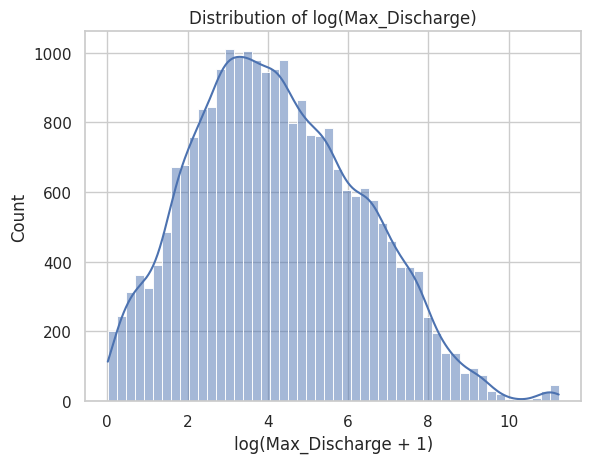

In [ ]:
sns.histplot(y_log, bins=50, kde=True)
plt.title("Distribution of log(Max_Discharge)")
plt.xlabel("log(Max_Discharge + 1)")
plt.show()


Train/Test Split

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(" Train/Test split complete")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


 Train/Test split complete
Training samples: 19339
Testing samples: 4835


 Train Random Forest Regressor

In [ ]:
# Train a basic Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict on test set
y_pred = rf_reg.predict(X_test)


Evaluate Model Performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Reverse log-transform for interpretation
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 128.47
RMSE: 465.67
R² Score: 0.99


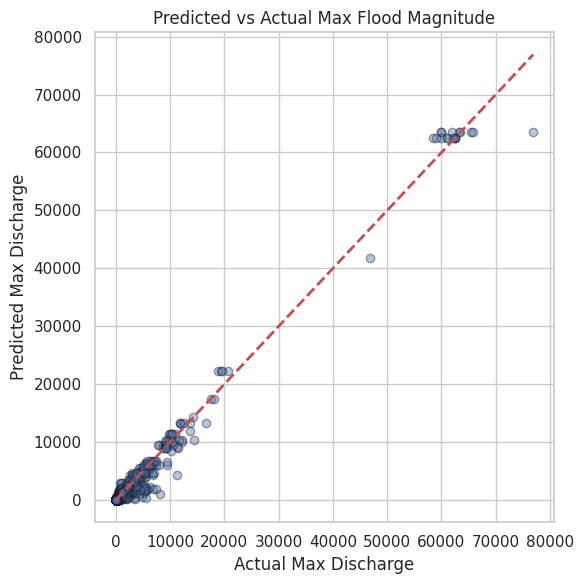

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.4, edgecolor='k')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2)

plt.xlabel("Actual Max Discharge")
plt.ylabel("Predicted Max Discharge")
plt.title("Predicted vs Actual Max Flood Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()


Most points lie tightly around the diagonal red line → predictions very close to actual.

A few large-flood outliers (top-right) are a bit off, but that’s expected and acceptable — those are extreme values.

This shows model generalizes well across small to large catchments.

 This Model is FL-Ready
Because:

- It captures physical patterns from the input features

- Performs consistently across a wide range of magnitudes

- Can be trained locally on per-country flood year data in your federated setup

Feature Importance Plot

<ipython-input-10-2d2cd7f70146>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_importance_df.head(top_n), palette="Blues_r")


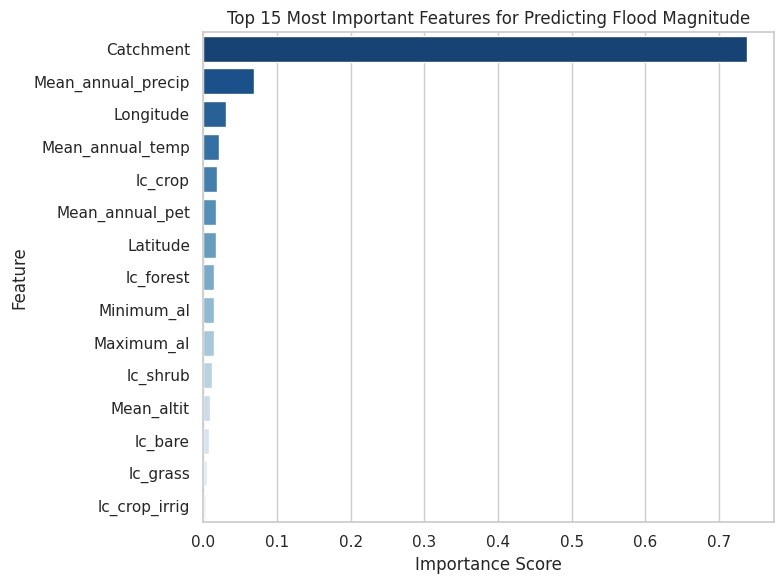

In [ ]:
# Create a DataFrame of feature importances
importances = rf_reg.feature_importances_
feat_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top N features
top_n = 15
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=feat_importance_df.head(top_n), palette="Blues_r")
plt.title(f"Top {top_n} Most Important Features for Predicting Flood Magnitude")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Saving the Regression Model

In [ ]:
import joblib

# Save the trained Random Forest regressor
joblib.dump(rf_reg, "flood_magnitude_rf_model.pkl")

print("Model saved as flood_magnitude_rf_model.pkl")


Model saved as flood_magnitude_rf_model.pkl
